# Tools 2 Final Project

Jen Lee
Connie Chang

In [1]:
import pandas as pd
import geopandas as gpd
import re
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt
from wordcloud import WordCloud

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


## Data Introduction

|Date Compiled |County/City|File Nale   |Description |
|:-------------|:---------:|:----------:|-----------:|
|29 March, 2021|Denver     |listings.csv|Summary information and metrics for listings in Denver (good for visualisations).|
|29 March, 2021|Denver     |calendar.csv| Detailed Calendar Data for listings in Denver|
|29 March, 2021|Denver     |reviews.csv| Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).|
|N/A|Denver     |neighbourhoods.csv| Neighbourhood list for geo filter. Sourced from city or open source GIS files.|
|N/A|Denver     |neighbourhoods.geojson| GeoJSON file of neighbourhoods of the city.|


Import each of the csv files. Not sure which ones we'll use yet, but might as well import all of them.



In [29]:
# listings.csv
listings = pd.read_csv("./data/denver_03_29_2021/listings.csv")
print(f"listings shape: {listings.shape}")
listings.head()

listings shape: (3394, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,177,https://www.airbnb.com/rooms/177,20210329150448,2021-03-30,Tiny Home in the Heart of the City- ECO FRIENDLY,"160 sq ft + 80 sq ft loft for sleeping, Sleeps...","Quiet neighborhood next to park, creeks and bi...",https://a0.muscache.com/pictures/a1745ab2-b3a0...,615,https://www.airbnb.com/users/show/615,...,10.0,10.0,9.0,2016-BFN-0004968,t,2,2,0,0,1.40
1,360,https://www.airbnb.com/rooms/360,20210329150448,2021-03-30,Sit in the Peaceful Garden of the Chickadee Co...,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,https://a0.muscache.com/pictures/monet/Select-...,666,https://www.airbnb.com/users/show/666,...,10.0,10.0,10.0,2017-BFN-0002177,f,2,2,0,0,4.34
2,364,https://www.airbnb.com/rooms/364,20210329150448,2021-03-31,Lodo / RiNo LOFT via airport train,"Modern 1,000 square foot loft in the heart of ...","Ten brewpubs within walking distance, two grea...",https://a0.muscache.com/pictures/11766413/a2c5...,783,https://www.airbnb.com/users/show/783,...,10.0,9.0,9.0,NaN,f,1,1,0,0,0.60
3,590,https://www.airbnb.com/rooms/590,20210329150448,2021-04-02,Comfortable - and a great value!,"Large guest room in my home, where I also live...",I love the diversity of my neighborhood and it...,https://a0.muscache.com/pictures/110931/30991c...,933,https://www.airbnb.com/users/show/933,...,10.0,10.0,10.0,2021-BFN-0000578,f,2,0,2,0,4.14
4,592,https://www.airbnb.com/rooms/592,20210329150448,2021-03-31,private,This room is in the basement. It does not hav...,NaN,https://a0.muscache.com/pictures/110942/171dd0...,933,https://www.airbnb.com/users/show/933,...,10.0,10.0,10.0,2021-BFN-0000578,f,2,0,2,0,1.06


In [3]:
# calendar.csv
calendar = pd.read_csv("./data/denver_03_29_2021/calendar.csv")
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,177,2021-03-30,f,$50.00,$50.00,1.0,1125.0
1,3280195,2021-03-29,f,"$1,000.00","$1,000.00",3.0,1125.0
2,3280195,2021-03-30,f,"$1,000.00","$1,000.00",3.0,1125.0
3,3280195,2021-03-31,f,"$1,000.00","$1,000.00",3.0,1125.0
4,3280195,2021-04-01,f,"$1,000.00","$1,000.00",3.0,1125.0


In [4]:
# reviews.csv
reviews = pd.read_csv("./data/denver_03_29_2021/reviews.csv")
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,177,99461681,2016-09-04,78348548,Brenna,"Great place to stay! Definitely a tiny home, b..."
1,177,101460574,2016-09-13,72125554,Rachael,Joe was very friendly and gave us all the info...
2,177,101681475,2016-09-14,21300329,Haley,Amazing property and Joe was a great host! Eve...
3,177,102963808,2016-09-19,53882399,Mike,"Joe was a great host, the description of this ..."
4,177,103447333,2016-09-22,94621370,Carol,He welcomes us when we first arrived and gave ...


In [5]:
# neighbourhoods.csv
neighborhoods = pd.read_csv("./data/denver_03_29_2021/neighbourhoods.csv")
neighborhoods.head()

,neighbourhood_group,neighbourhood
0,NaN,Athmar Park
1,NaN,Auraria
2,NaN,Baker
3,NaN,Barnum
4,NaN,Barnum West


In [6]:
neighborhoods_gdf = gpd.read_file("./data/denver_03_29_2021/neighbourhoods.geojson")
neighborhoods_gdf.head()

,neighbourhood,neighbourhood_group,geometry
0,Chaffee Park,None,"MULTIPOLYGON (((-104.99812 39.79102, -104.9981..."
1,Sunnyside,None,"MULTIPOLYGON (((-104.99818 39.78256, -104.9982..."
2,Highland,None,"MULTIPOLYGON (((-104.99820 39.76930, -104.9982..."
3,University,None,"MULTIPOLYGON (((-104.95945 39.68473, -104.9594..."
4,Globeville,None,"MULTIPOLYGON (((-104.96875 39.79104, -104.9688..."


## Data Cleaning

In [30]:
# listings.csv

# remove unneeded columns
listings.drop(columns=["picture_url", "host_url", "host_thumbnail_url", "host_picture_url", "license", 'scrape_id', 
               'listing_url','last_scraped', 'neighborhood_overview','host_location','host_verifications' ,
               'host_about', 'host_thumbnail_url','amenities','host_neighbourhood', 'neighbourhood', 'name',
               'description','host_name', 'calendar_last_scraped'], axis=1, inplace=True)
print(listings.shape)
# TODO: replace all empty columns with NaN

# change columns with 't' & 'f' to booleans
def convert_to_bool(x):
    if x == "t":
        return True
    elif x == "f":
        return False
    else:
        return np.NaN

listings["host_is_superhost"] = listings["host_is_superhost"].apply(lambda x: convert_to_bool(x))
listings["host_identity_verified"] = listings["host_identity_verified"].apply(lambda x: convert_to_bool(x))
listings["has_availability"] = listings["has_availability"].apply(lambda x: convert_to_bool(x))
listings["instant_bookable"] = listings["instant_bookable"].apply(lambda x: convert_to_bool(x))

# Clean up the "bathrooms_text" column to make two new columns - number of bathrooms, and a boolean column to indicate if bthrooms are private
def get_bathrooms_num(x):
    if type(x) != str:
        return 0.0
    elif x == "Shared half-bath" or x == "Half-bath":
        return 0.5
    elif "shared bath" in x:
        return float(x.strip("s").strip("shared bath"))
    elif "private bath" in x:
        return float(x.strip("s").strip("private bath"))
    elif "bath" in x:
        return float(x.strip("s").strip("bath"))
    else:
        return 0.0
    
def get_is_private_bathroom(x):
    if type(x) != str:
        return np.NaN
    elif "shared" in x:
        return False
    else:
        return True

listings["bathrooms"] = listings["bathrooms_text"].apply(lambda x: get_bathrooms_num(x))
listings["private_bathroom"] = listings["bathrooms_text"].apply(lambda x: get_is_private_bathroom(x))
listings["private_bathroom"] = listings["private_bathroom"].apply(lambda x: convert_to_bool(x))
listings = listings.drop("bathrooms_text", axis=1)

# Convert the latitude & longitude values to Point() values, to be used later for plotting
listings["coordinates"] = [Point(xy) for xy in zip(listings.longitude, listings.latitude)]

# display head to show success
listings.head()


(3394, 55)


,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,private_bathroom,coordinates
0,177,615,2008-07-07,within an hour,100%,100%,True,2.0,2.0,t,...,10.0,9.0,True,2,2,0,0,1.40,True,POINT (-104.92489 39.69551)
1,360,666,2008-07-08,within an hour,100%,91%,True,2.0,2.0,t,...,10.0,10.0,False,2,2,0,0,4.34,True,POINT (-105.00316 39.76758)
2,364,783,2008-07-11,NaN,NaN,NaN,False,1.0,1.0,t,...,9.0,9.0,False,1,1,0,0,0.60,True,POINT (-104.97906 39.76672)
3,590,933,2008-07-21,within an hour,100%,83%,True,2.0,2.0,t,...,10.0,10.0,False,2,0,2,0,4.14,False,POINT (-104.91109 39.75511)
4,592,933,2008-07-21,within an hour,100%,83%,True,2.0,2.0,t,...,10.0,10.0,False,2,0,2,0,1.06,False,POINT (-104.91106 39.75481)


### Convert Data Type
1. Convert to numeric: 'host_response_rate' and 'host_acceptance_rate' are object, remove '%' and convert to numeric
2. Convert to Datetime: 'host_since', 'first_review', 'last_review'

In [31]:
# Remove % sign and convert the data type to numeric
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str[:-1])
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'].str[:-1])

# Datetime format:
listings.host_since = pd.to_datetime(listings.host_since, format='%Y-%m-%d')
listings.first_review = pd.to_datetime(listings.first_review, format='%Y-%m-%d')
listings.last_review = pd.to_datetime(listings.last_review, format='%Y-%m-%d')

### Dropping Data
1. Records with price = 0.
2. Drop all NA columns 'neighbourhood_group_cleansed','calendar_updated'
3. There are 4 records with NA in both bathrooms_text fields.
4. Drop records with NA in host_identity_verified as these may not be verified to be trust worthy hosts.

In [33]:
# drop the record with price = 0
listings = listings[listings['price']!='$0.00']

# drop records with host_verified na and private_bathroom na(no data from bathroom_text)
listings.dropna(subset=['private_bathroom'], inplace=True)
listings.dropna(subset=['host_identity_verified'], inplace=True)

# drop all na columns
listings.drop(['neighbourhood_group_cleansed','calendar_updated'], axis=1, inplace=True)

In [41]:
print(f"after dropping listings df shape: {listings.shape}")
listings.info()

after dropping listings df shape: (3239, 54)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 0 to 3393
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            3239 non-null   int64         
 1   host_id                                       3239 non-null   int64         
 2   host_since                                    3239 non-null   datetime64[ns]
 3   host_response_time                            2921 non-null   object        
 4   host_response_rate                            2921 non-null   float64       
 5   host_acceptance_rate                          3008 non-null   float64       
 6   host_is_superhost                             3239 non-null   object        
 7   host_listings_count                           3239 non-null   float64       
 8   host_total_listings_cou

### Fill in NA
1. "Bedroom" field with blank are the ones that either a studio, or an open space without separate room as a bedroom, so we fill it with 0.
2. "Beds" field with blank typically means that the listing host missed the field. The main point of airbnb is bed, we'd assume they have at least 1 bed, so fill in the blank ones with 1.
3. "Reviews_per_month" field with blank means there's no review at all. Thus, the "first_review" and "last_review" fields are both blank. We'd fill the "reviews_per_month" with 0.
4. Fill numerical columns with mean.
5. Fill categorical columns with 'missing'.

In [47]:
# FunctionTransformer for fill NA 
from sklearn.preprocessing import FunctionTransformer
def custom_transformation(df):
  df.bedrooms.fillna(0, inplace=True)
  df.beds.fillna(1, inplace=True)
  df.reviews_per_month.fillna(0, inplace=True)

ft = FunctionTransformer(func=custom_transformation, validate=False)
ft.fit_transform(listings)


#Numeric columns :
numFeatures = listings.drop(['price'], axis=1).select_dtypes(include=['int64', 'float64']).columns

#Categorical columns :
catFeatures = listings.select_dtypes(include=['object']).columns

listings[numFeatures] = listings[numFeatures].fillna(listings.mean().iloc[0])
listings[catFeatures] = listings[catFeatures].fillna('missing')

# pd.set_option('display.max_rows',None)
# listings.isna().sum()

C:\Users\Connie Chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


### Price Field
'price' field is with type: object. It needs to remove '$' and ',' then convert to numeric.

In [35]:
print(f"listing price initial type: {listings.price.dtype}")

# remove '$' and ','
listings['price'] = listings['price'].str.strip('$')
listings['price'] = listings['price'].str.replace(',', '')

# convert to numeric
listings['price'] = pd.to_numeric(listings['price'])

print(f"listing price after cleaning type: {listings.price.dtype}")

listings['price'].describe()

listing price initial type: object
listing price after cleaning type: float64


count    3239.000000
mean      157.894412
std       249.079138
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

### Add Neighbourhood Group column

In [7]:
# add neighboorhood group
neighbourhoods_group = pd.read_csv("https://docs.google.com/spreadsheets/d/1EhAbM7f115MAFsDZxrbCTX4Dr4Nrq_yGQdgRfizTeVM/export?format=csv")

listings = pd.merge(listings, neighbourhoods_group, on='neighbourhood_cleansed',  
         how='left', validate='m:1')

listings[['neighbourhood_cleansed','neighbourhood_group']].sample(5)

,neighbourhood_cleansed,neighbourhood_group
1808,North Capitol Hill,Central
965,Ruby Hill,West
1109,Harvey Park South,Southwest
953,CBD,Central
1205,Stapleton,Northeast


In [ ]:
# Maybe TODO: Make a table called 'hosts'
# - index - hostID (from listings df)
# - num_listings (from listings df, find num rows their hostID appears in)
# - listings (array of listingIDs)
# - availability (nights it was rented in calendar df / total days)
# - is_superhost (from listings df)
# - profit (add up all the money their listings make from the calender table)

# Could use this as an analysis of of 'how much can you make as an AirBnb host in Denver?'


## Visualizations

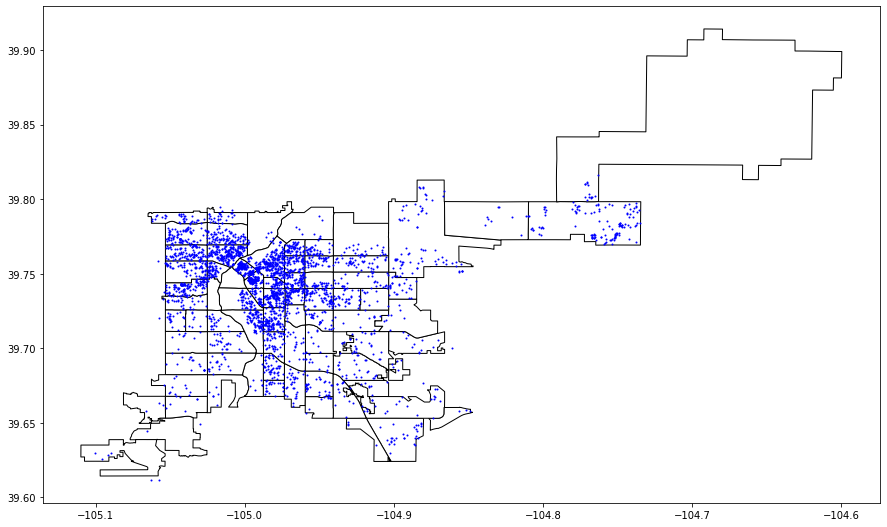

In [17]:
# Plot all the coordinates from the listings on the neighborhoods map
listings_gdf = gpd.GeoDataFrame(listings, geometry="coordinates")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax = neighborhoods_gdf.plot(color="white", edgecolor="black", ax=ax)
listings_gdf.plot(ax=ax, color="blue", markersize=1)

plt.show()

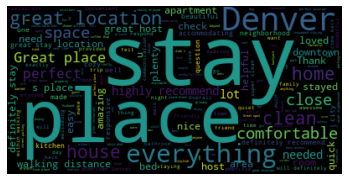

In [11]:
# make a word cloud with all the reviews text

# function to lump all the text together
def lumpText(text_array):
    lump = ""
    for i in text_array:
        lump += str(i) + " "
    return lump

# generate wordcloud
reviews_lump_text = lumpText(reviews["comments"].values)
reviews_wordcloud = WordCloud().generate(reviews_lump_text)

# plot
plt.imshow(reviews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Neighbourhood price box plot


<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

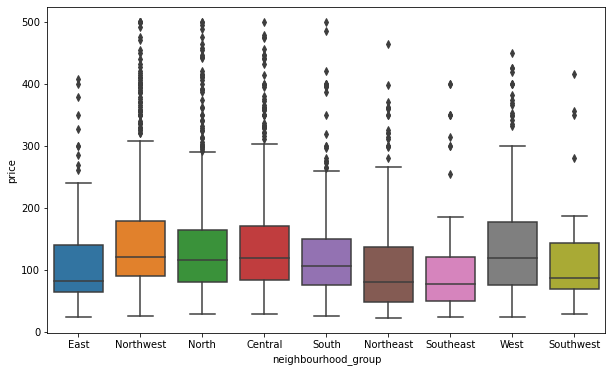

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(y='price',x='neighbourhood_group', data = listings[listings['price']<=500])